In [1]:
import torch
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch import nn
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import random

c:\Users\18raj\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# img, label = train_dataset[0], train_dataset[1]
img, label = X_train, y_train

c:\Users\18raj\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


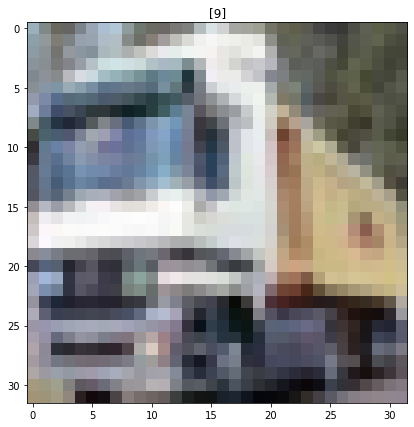

In [3]:
plt.figure(figsize=(10, 7))
plt.imshow(img[1])
plt.title(label[1])
plt.show()

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(40000, 32, 32, 3) (10000, 32, 32, 3) (40000, 1) (10000, 1)


In [5]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.length = len(X)
        self.X = X/255.0
        self.y = y
    def __len__(self):
        return self.length
    def transformHorizontal(self, img):
        for cni, cn in enumerate(img):
            for rowi, row in enumerate(img[cni]):
                img[cni][rowi] = np.flip(row)
        return img
    def transformVertical(self, img):
        for cni, cn in enumerate(img):
            img[cni] = np.flip(cn)
        return img
    def __getitem__(self, idx):
        X = np.moveaxis(self.X[idx], 2, 0)
        y = self.y[idx].squeeze()
        rnd = random.randint(0, 5)
        if rnd == 0:
            X = self.transformHorizontal(X)
        elif rnd == 1:
            X = self.transformVertical(X)
        X_tensor = torch.from_numpy(X).to(torch.float32)
        y_tensor = torch.tensor(y).to(torch.long)
        return X_tensor, y_tensor

In [6]:
train_data = MyDataset(X_train, y_train)
val_data = MyDataset(X_val, y_val)
test_data = MyDataset(X_test, y_test)

In [7]:
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

In [8]:
next(iter(train_dataloader))

[tensor([[[[0.5804, 0.5725, 0.5843,  ..., 0.5608, 0.5569, 0.5608],
           [0.5725, 0.5647, 0.5020,  ..., 0.5216, 0.5216, 0.5255],
           [0.5686, 0.4588, 0.2000,  ..., 0.4902, 0.4863, 0.4941],
           ...,
           [0.4549, 0.4431, 0.4392,  ..., 0.3490, 0.3529, 0.3647],
           [0.4588, 0.4431, 0.4392,  ..., 0.3529, 0.3569, 0.3647],
           [0.4196, 0.4078, 0.4039,  ..., 0.3647, 0.3686, 0.3765]],
 
          [[0.7137, 0.7020, 0.7137,  ..., 0.7333, 0.7294, 0.7373],
           [0.7059, 0.6941, 0.6196,  ..., 0.7020, 0.7020, 0.7098],
           [0.7216, 0.5725, 0.2706,  ..., 0.6824, 0.6784, 0.6863],
           ...,
           [0.6824, 0.6627, 0.6588,  ..., 0.5569, 0.5608, 0.5765],
           [0.6824, 0.6627, 0.6588,  ..., 0.5608, 0.5647, 0.5765],
           [0.6275, 0.6118, 0.6078,  ..., 0.5804, 0.5843, 0.5922]],
 
          [[0.4078, 0.3882, 0.3961,  ..., 0.3804, 0.3804, 0.3804],
           [0.3922, 0.3961, 0.3843,  ..., 0.3373, 0.3373, 0.3412],
           [0.3725, 0.32

In [71]:
class Cifar(nn.Module):
    def __init__(self, input_size, hidden_units, output_size, shape):
        super(Cifar, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=input_size, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*shape*shape, out_features=hidden_units*(shape+2)*(shape+2)),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units*(shape+2)*(shape+2), out_features=hidden_units*(shape+5)*(shape+5)),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units*(shape+5)*(shape+5), out_features=output_size)
        )
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.conv1(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.dropout(x)
        # x = self.conv2(x)
        # x = self.dropout(x)
        x = self.classifier(x)
        return x

In [72]:
model = Cifar(input_size=3, hidden_units=10, output_size=10, shape=5)
model

Cifar(
  (conv1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=250, out_features=490, bias=True)
    (2): ReLU()
    (3): Linear(in_features=490, out_features=1000, bias=True)
    (4): ReLU()
    (5): Linear(in_features=1000, out_features=10, bias=True)
  )
  (dropout): Dropout(p=0.25, inplace=False)
)

In [73]:
def train(model: nn.Module,
        loss_fn: nn.Module,
        optimizer: torch.optim.Optimizer,
        dataloader: torch.utils.data.DataLoader,
        device="cpu"
    ):
    model.train()
    train_loss, accuracy = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        accuracy += (y_pred_class == y).sum().item()/len(y_pred)
    train_loss = train_loss/len(dataloader)
    accuracy = accuracy/len(dataloader)
    return train_loss, accuracy

In [74]:
def test(model: nn.Module,
        loss_fn: nn.Module,
        dataloader: torch.utils.data.DataLoader,
        device="cpu"
    ):
    model.eval()
    test_loss, accuracy = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()
            
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            accuracy += (y_pred_class == y).sum().item()/len(y_pred)
    test_loss = test_loss/len(dataloader)
    accuracy = accuracy/len(dataloader)
    return test_loss, accuracy

In [75]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [76]:
results = {
    "train_loss": [],
    "train_accuracy": [],
    "test_loss": [],
    "test_accuracy": []
}

epochs = 10
for epoch in range(epochs):
    train_loss, train_acc = train(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    test_loss, test_acc = test(model=model,
                                    dataloader=val_dataloader,
                                    loss_fn=loss_fn)
    
    print(f"Epoch: {epoch+1} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")
    results["train_loss"].append(train_loss)
    results["train_accuracy"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_accuracy"].append(test_acc)

Epoch: 1 | Train Loss: 1.9482 | Train Acc: 0.2633 | Test Loss: 1.7354 | Test Acc: 0.3503
Epoch: 2 | Train Loss: 1.6890 | Train Acc: 0.3783 | Test Loss: 1.5947 | Test Acc: 0.4063
Epoch: 3 | Train Loss: 1.5923 | Train Acc: 0.4202 | Test Loss: 1.4928 | Test Acc: 0.4491
Epoch: 4 | Train Loss: 1.5292 | Train Acc: 0.4442 | Test Loss: 1.5287 | Test Acc: 0.4410
Epoch: 5 | Train Loss: 1.4823 | Train Acc: 0.4619 | Test Loss: 1.3999 | Test Acc: 0.4856
Epoch: 6 | Train Loss: 1.4456 | Train Acc: 0.4778 | Test Loss: 1.3994 | Test Acc: 0.4966
Epoch: 7 | Train Loss: 1.4150 | Train Acc: 0.4864 | Test Loss: 1.3677 | Test Acc: 0.5068
Epoch: 8 | Train Loss: 1.3960 | Train Acc: 0.4955 | Test Loss: 1.3107 | Test Acc: 0.5263
Epoch: 9 | Train Loss: 1.3677 | Train Acc: 0.5063 | Test Loss: 1.2927 | Test Acc: 0.5349
Epoch: 10 | Train Loss: 1.3452 | Train Acc: 0.5164 | Test Loss: 1.2911 | Test Acc: 0.5322


In [77]:
test_loss, test_acc = test(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

Test Loss: 1.2997 | Test Acc: 0.5319
